In [2]:
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X) Data ,
    
    X^T * X = CovX = U *d* U^T where the columns of E are the normalized eigenvectors
    D=d^(-1/2), the whitening matrix is W = E * D * E^T: Xw = X*W
    Cov Xw = Xw^T*Xw = E*D*E^T*X^T*X*E*D*E^T = E*D*E^T*CovX*E*D*E^T = E*D*E^T*E *d* E^T*E*D*E^T = I
    The inverse is W^-1: W^-1 = E * D^(-1) * E^T
    The un-whitened matrix is X = (X*W)*W^-1

    Input:
    -X (numpy array): input data, rows are data points, columns are features
    
    Output:
    -X_mean (array): mean of X
    -W (matrix): dewhitening matrix
    """

    EPS = 10e-18
    upperBound=10e14
    meanX = np.mean(X, axis=0)
    Xc = X - meanX

    cov = np.dot(Xc.T, X)/float(Xc.shape[0]-1.0)

    U,d, _ = np.linalg.svd(cov)
    d = np.sqrt(np.clip(a=d, a_min=EPS, a_max=upperBound))
    D_whiten = np.diag(1. / d)
    D_dewhiten = np.diag(d)    
    W = np.dot(np.dot(U, D_whiten), U.T)
    W_dewhiten = np.dot(np.dot(U, D_dewhiten), U.T)
    X_white = np.dot(Xc, W)

    # test
    test1 = np.std(X_white, axis=0)
    test2 = np.add(np.dot(X_white, W_dewhiten),meanX)
    print("white reconstruction error: "+str(np.max( X-test2 )))
    print("white standardization error: " + str(np.max(test1 - np.ones(test1.shape))))
    
    return meanX, W

(40000, 4)
white reconstruction error: 9.458545058294021e-13
white standardization error: -1.392025942714703e-05
 Starting Training...
 Epoch 0/1000 - Loss: 176786.5472 - Time: 0.78 sec
 Epoch 100/1000 - Loss: 126109.9213 - Time: 1.57 sec
 Epoch 200/1000 - Loss: 90675.9999 - Time: 2.25 sec
 Epoch 300/1000 - Loss: 71803.8109 - Time: 2.94 sec
 Epoch 400/1000 - Loss: 59784.4525 - Time: 3.63 sec
 Epoch 500/1000 - Loss: 69130.8541 - Time: 4.31 sec
 Epoch 600/1000 - Loss: 69927.5042 - Time: 4.99 sec
 Epoch 700/1000 - Loss: 62358.6825 - Time: 5.68 sec
 Epoch 800/1000 - Loss: 44331.0002 - Time: 6.37 sec
 Epoch 900/1000 - Loss: 41620.0914 - Time: 7.05 sec
 Training Completed in 7.74 sec!
✔️ Posterior Mean (after scaling):
 [[ 0.12332642  1.39325674  5.02693355 -0.19939893]
 [ 0.09722284  2.12734793  1.76617622 -0.73569539]
 [ 0.06359713  1.43067916  2.28354335 -0.76944023]
 [ 0.06366151  1.1898077   4.31353003 -0.44601727]
 [ 0.09948457  1.90977202  1.97006762 -0.44410008]]
✔️ Posterior Std (af

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


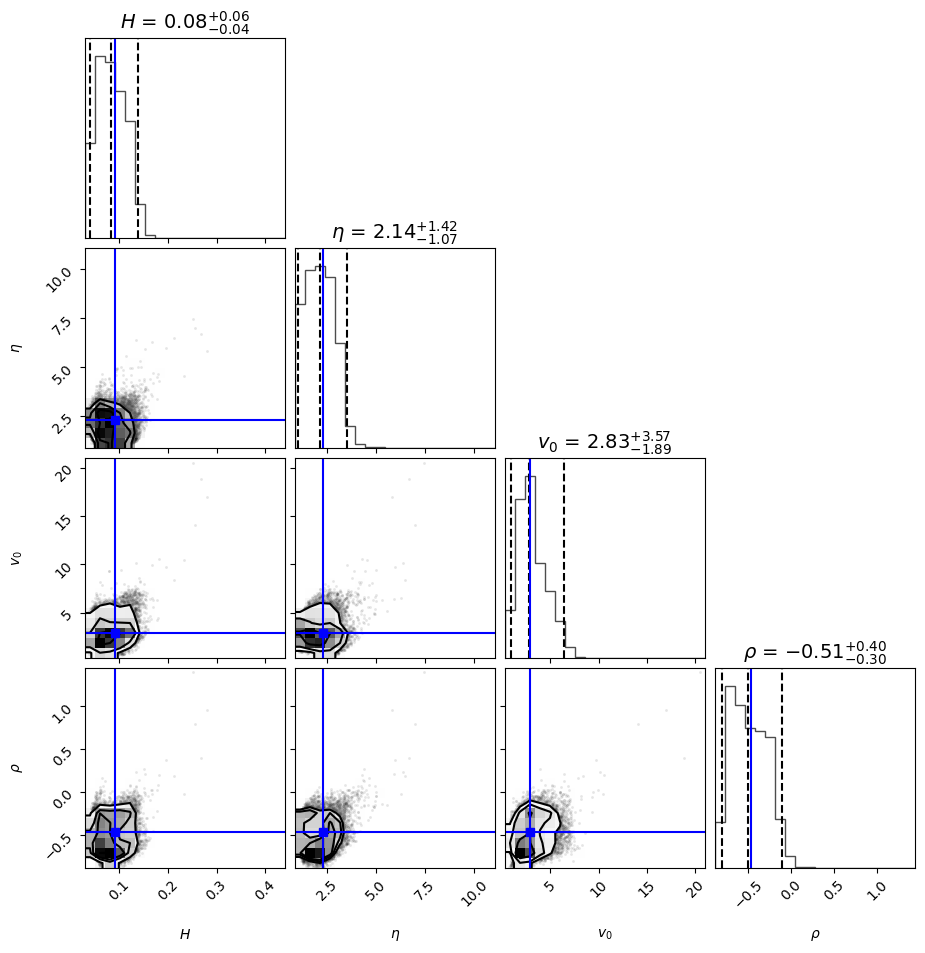

In [3]:
import gzip
import matplotlib.ticker as mtick
import pandas as pd 
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import time
import numpy as np
import corner
import matplotlib.pyplot as plt

#  Step 1: Bayesian Neural Network Class

class BayesianNN(PyroModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Bayesian layer 1
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 0.1).expand(self.fc1.weight.shape).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 0.1).expand(self.fc1.bias.shape).to_event(1))

        # Bayesian layer 2
        self.fc2 = PyroModule[nn.Linear](hidden_dim, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 0.1).expand(self.fc2.weight.shape).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 0.1).expand(self.fc2.bias.shape).to_event(1))

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        output = self.fc2(x)  # Linear output (real-valued parameters)

        
        sigma = pyro.sample("sigma", dist.LogNormal(-1.0, 0.5).expand([output.shape[-1]]).to_event(1))

        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Normal(output, sigma).to_event(1), obs=y)

        return output


# Step 2: Load and Scale Data
f = gzip.GzipFile('Bergomi1FactorTrainSet copy.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])



# Prepare storage for volatilities (IV surfaces) and model parameters
volatilities = {}
parameter = {}

# Use yy as volatilities (Implied Volatility Surfaces)
volatilities['train'] = pd.DataFrame(yy[:int(0.8 * len(yy))])  # 80% train
volatilities['test'] = pd.DataFrame(yy[int(0.8 * len(yy)):])  # 20% test

# Use xx as model parameters (Rough Bergomi Parameters)
parameter['train'] = pd.DataFrame(xx[:int(0.8 * len(xx))])  
parameter['test'] = pd.DataFrame(xx[int(0.8 * len(xx)):])      
X_mean, W = zca_whiten(yy[:int(0.8 * len(yy))])
volatilities_white = {
    'train': pd.DataFrame(np.dot(volatilities['train'].values - X_mean, W)),
    'test': pd.DataFrame(np.dot(volatilities['test'].values - X_mean, W))
}              


parameter_names = ["H", "eta", "v0", "rho"]
ub = np.array([0.16, 4, 10, 0])
lb = np.array([0.01, 0.5, 0, -1])

def myscale_0_1(x):
    return (np.array(x) - lb) / (ub - lb)

def myinverse_0_1(x):
    return x * (ub - lb) + lb

X_train = torch.tensor(volatilities_white['train'].values, dtype=torch.float32)
X_test = torch.tensor(volatilities_white['test'].values, dtype=torch.float32)

y_train = torch.tensor(myscale_0_1(parameter['train'].values), dtype=torch.float32)
y_test = torch.tensor(myscale_0_1(parameter['test'].values), dtype=torch.float32)


# Step 3: Setup BNN Model

input_dim = X_train.shape[1]  # 88 features (IV Surface)
hidden_dim = 50
output_dim = y_train.shape[1]  # 4 (Rough Bergomi parameters)

bnn = BayesianNN(input_dim, hidden_dim, output_dim)


# Step 4: Guide (Variational Inference)

guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)


# Step 5: Training with SVI

optimizer = Adam({"lr": 1e-3})
svi = SVI(bnn, guide, optimizer, loss=Trace_ELBO())

num_epochs = 1000
losses = []
# Reset Pyro's parameter store to start fresh
pyro.clear_param_store()
start_time = time.time()
print(" Starting Training...")

for epoch in range(num_epochs):
    loss = svi.step(X_train, y_train)
    losses.append(loss)

    #  Print every 100 epochs
    if epoch % 100 == 0:
        elapsed_time = time.time() - start_time
        print(f" Epoch {epoch}/{num_epochs} - Loss: {loss:.4f} - Time: {elapsed_time:.2f} sec")

print(f" Training Completed in {time.time() - start_time:.2f} sec!")


#  Step 6: Posterior Sampling

num_samples = 100
posterior_samples = [guide(None) for _ in range(num_samples)]
posterior_preds = [pyro.poutine.condition(bnn, sample)(X_test) for sample in posterior_samples]

posterior_preds = torch.stack(posterior_preds)  # Shape: (num_samples, num_test, output_dim)


# Step 7: Convert Back to Original Scale

posterior_mean = posterior_preds.mean(0).detach().numpy()
posterior_std = posterior_preds.std(0).detach().numpy()

posterior_mean_original = myinverse_0_1(posterior_mean)
posterior_std_original = posterior_std * (ub - lb)  


# Step 8: Validate Posterior Scaling

print(f"✔️ Posterior Mean (after scaling):\n", posterior_mean_original[:5])
print(f"✔️ Posterior Std (after scaling):\n", posterior_std_original[:5])
print(f"Min Posterior Std (after scaling):", posterior_std_original.min(axis=0))
print(f"Max Posterior Std (after scaling):", posterior_std_original.max(axis=0))


#Step 9: Plot Posteror Distributions

param_labels = [r"$H$", r"$\eta$", r"$v_0$", r"$\rho$"]
true_params = np.median(xx, axis=0)  # True parameters (median)

fig = corner.corner(
    posterior_mean_original,
    labels=param_labels,
    truths=true_params,
    truth_color="blue",
    quantiles=[0.025, 0.5, 0.975],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 14},
    hist_kwargs={"density": True, "alpha": 0.7}
)
plt.savefig("BayesianBNN.eps", format="eps", dpi=300)
plt.show()


In [3]:
import torch

# Save BNN model
torch.save(bnn.state_dict(), "bnn_model.pth")

# Save training time (assuming you stored `bnn_train_time`)
bnn_train_time = time.time() - start_time  # Compute training time
np.save("bnn_time.npy", np.array([bnn_train_time]))  # Save as numpy array

print(f" BNN Model Saved! Training Time: {bnn_train_time:.2f} sec")

 BNN Model Saved! Training Time: 18.64 sec


In [4]:
import numpy as np

# Load training times
bnn_train_time = np.load("bnn_time.npy")[0]  # Load BNN training time
mcmc_train_time=4*60+42.4

# Compare training times
speedup = mcmc_train_time / bnn_train_time

print(f" BNN Training Time: {bnn_train_time:.2f} sec")
print(f" MCMC Training Time: {mcmc_train_time:.2f} sec")
print(f" BNN is {speedup:.2f}x Faster than MCMC!")

 BNN Training Time: 18.64 sec
 MCMC Training Time: 282.40 sec
 BNN is 15.15x Faster than MCMC!
